In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


data_path = "/home/clairegayral/Documents/openclassroom/data/P5/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P5/"

## my .py : 
from script01_duplicates import *
from script02_missing_values_treatment import *
from script03_univariate_analysis import *
from script04_multivariate_analysis import *
from script05_CV_regression import *
from script06_reduce_dim import *

## extract list of text :
from bs4 import BeautifulSoup
import re
# from sklearn.feature_extraction.s import s# import ENGLISH_STOP_WORDS

# from sklearn import model_selection 
# from sklearn import preprocessing
# from sklearn import neighbors
# from sklearn import linear_model

# from sklearn.impute import KNNImputer
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import fbeta_score
# from sklearn.metrics import make_scorer
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import fowlkes_mallows_score
# from sklearn.metrics.pairwise import pairwise_kernels


# from sklearn.preprocessing import OneHotEncoder
# from sklearn.linear_model import LogisticRegression

# from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram


from bs4 import BeautifulSoup
import nltk
from collections import defaultdict
from nltk.stem.snowball import EnglishStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.utils import tokenize
from gensim import corpora
from gensim import models
from gensim.models import FastText

# Mission

Dans un premier notebook, les posts tagués ont été extraits, et prétraités. De ce travail, les textes sont laissés sous forme de "bag of word", une liste de mots d'intérêt appelés tokens. Pour les variables de sortie dans l'apprentissage supervisé, seulement quelques tags sont gardés, afin de limiter la complexité de calculs. Il sera possible de généraliser cela.

## Rappel des consignes :

* Mettre en œuvre une approche non supervisée.
* Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
* Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
* Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
* Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.


## Livrable attendu ici
Un notebook de test de différents modèles (non cleané, pour comprendre votre démarche)


# Ressources : 
## LDA 
* Une explication générale : https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2
* Un cours plus détaillé (approche plus proba) : https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiykLO95Yj1AhWkzYUKHT2hBI4QFnoECAUQAQ&url=http%3A%2F%2Falberto.bietti.me%2Ffiles%2Frapport-lda.pdf&usg=AOvVaw1tuLV60ncpf3PIqb3PN0DE
* 3eme ressource : https://www.analyticsvidhya.com/blog/2021/06/part-2-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/


* LDA sklearn documentation : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
## Gradient Boosting :

# Plan du notebook :

Pour faciliter la lecture, il est possible de revenir à ce sommaire, en cliquant sur [back to menu](#menu) chaque fois qu'il apparaît. A partir de ce menu, il est possible de naviguer entre les parties en cliquant sur leur titre.


<a id ="menu"></a>
1. [Les posts](#section1)
    1. [Import du travail précédent](#section1.1)
    2. [Séparation des données](#section1.2)
    
2. [Approche non supervisée](#section2)
    0. [Random Forest](#section2.0)
    1. [LDA - apprentissage](#section2.1)
    2. [LDA - Prédiction](#section2.2)
    
3. [Approche supervisée](#section3)
    1. [Gradient Boosting](#section1.2)
        2. [](#section3.1.1)
        3. [](#section3.1.2)
        4. [](#section3.1.3)   
    2. [Bert ?](#section3.2)
        1. [](#section3.2.1)
        2. [](#section3.2.2)
        3. [](#section3.2.3)       
        4. [](#section3.2.4)

<a id ="section1"></a>
<a id ="section1.1"></a>

[back to menu](#menu)

# 1.Les posts
## 1.A Import du travail précédent

In [2]:
## Posts Lemmatized :
with open(res_path+"posts_cleanned_corpora_tokens"+".pkl", "rb") as f :
    corpora = pickle.load(f)

In [3]:
len(corpora)

11095

Comme proposé dans [ce post](https://thatascience.com/learn-machine-learning/save/), j'utilise la fonction "CountVectorizer" de sklearn pour passer en one ot encoding (sans visualisation possible car matrice sparse)

In [4]:
countvec = CountVectorizer(ngram_range=(1,4), 
                           stop_words='english',  
                           strip_accents='unicode',
                           max_features=10000)
X = countvec.fit_transform(pd.Series(corpora))
X

<11095x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 325452 stored elements in Compressed Sparse Row format>

In [5]:
X_df = pd.DataFrame(X.toarray(), index=corpora.keys())

In [6]:
## passer en list de tokens : 
# {k:text.split(" ") for k,text in corpora.items()}

In [7]:
## tags :



## 1.B Séparation des données

Pour comparer les données, je vais séparer mon ensemble de posts en apprentissage et test. Le premier servira à apprendre les modèles, le deuxième à comparer les prédictions entre les différents modèles 

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X_df)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
69565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31567,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29142,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97532,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Et pour avoir accès aux indices : 

In [9]:
train_index = X_train.index#pd.DataFrame(X.toarray(), index = list(corpora.keys())).iloc[X_train.indices,:].index
test_index = X_test.index

Pour être consistant entre les modèles suivants, j'enregistre cette spéaration train/test : 

In [10]:
# with open(res_path+"train_test_split"+".pkl", "wb") as f :
#     pickle.dump((train_index,test_index), f, pickle.HIGHEST_PROTOCOL)

Je peux donc partir de cette cellule pour la suite : 

In [11]:
## open corpora : 
with open(res_path+"posts_cleanned_corpora_tokens"+".pkl", "rb") as f :
    corpora = pickle.load(f)
## import train/test split index :    
with open(res_path+"train_test_split"+".pkl", "rb") as f :
    (train_index,test_index) = pickle.load(f)

n_features = 1000 
## choose vectorizer : 
countvec = CountVectorizer(max_features=n_features,
                          stop_words='english', strip_accents='unicode',)
X = countvec.fit_transform(pd.Series(corpora))
## get right index and split :
X = pd.DataFrame(X.toarray(), index = corpora.keys())
X_train = X.loc[train_index,:]
X_test = X.loc[test_index,:]

In [12]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
44917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37525,0,0,0,0,1,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
87818,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
75156,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59786,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
88269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


<a id ="section2"></a>
<a id ="section2.1"></a>
[back to menu](#menu)

# 2. Approche non supervisé
## 2.A LDA - code de base 
Pour lancer la LDA, la [documentation de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) est très claire. 

In [13]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X_train)

LatentDirichletAllocation(n_components=5, random_state=0)

In [14]:
lda.transform(X_test)

array([[5.52925013e-01, 1.67497105e-02, 3.96442572e-01, 1.67152722e-02,
        1.71674324e-02],
       [8.68368357e-01, 8.07268432e-03, 8.22684357e-03, 8.07177979e-03,
        1.07260336e-01],
       [5.75771957e-04, 5.62578844e-04, 7.69020420e-02, 5.63969134e-04,
        9.21395638e-01],
       ...,
       [5.65180521e-03, 6.53946784e-01, 5.73821606e-03, 3.28934805e-01,
        5.72838956e-03],
       [6.10911659e-01, 7.83239771e-03, 7.98487692e-03, 1.64698251e-01,
        2.08572815e-01],
       [7.78156029e-03, 7.78756336e-03, 7.91302881e-03, 7.32659742e-01,
        2.43858106e-01]])

Pour interpréter les résultats cependant, ce n'est pas si simple. D'autant qu'il faut tester différentes valeurs de n_components, mais aussi le learning_decay. Pour aller plus vite, penser à choisir n_jobs (parallèlisation) 

<a id ="section2.2"></a>
[back to menu](#menu)

## 2.B Comparaison LDA/NMF 
[Une page de scikit](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py) propose de comparer différentes méthodes d'extraction de topic. J'ai modifié le code pour le lancer sur mes postes stackoverflow : 

In [15]:
# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time.time()
data_samples = [corpora[k] for k in train_index]
print("done in %0.3fs." % (time.time() - t0))

Loading dataset...
done in 0.002s.


In [16]:
n_features = 1000
n_components = 10
n_samples = 2000
n_top_words = 20

In [17]:
# from time.time import time.time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [18]:
## Preprocess text :

# Use tf-idf features for NMF 
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, )
    #stop_words="english") ## already removed
t0 = time.time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time.time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features,# stop_words="english"
)
t0 = time.time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time.time() - t0))
print()

Extracting tf-idf features for NMF...
done in 0.194s.
Extracting tf features for LDA...
done in 0.183s.



Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.181s.


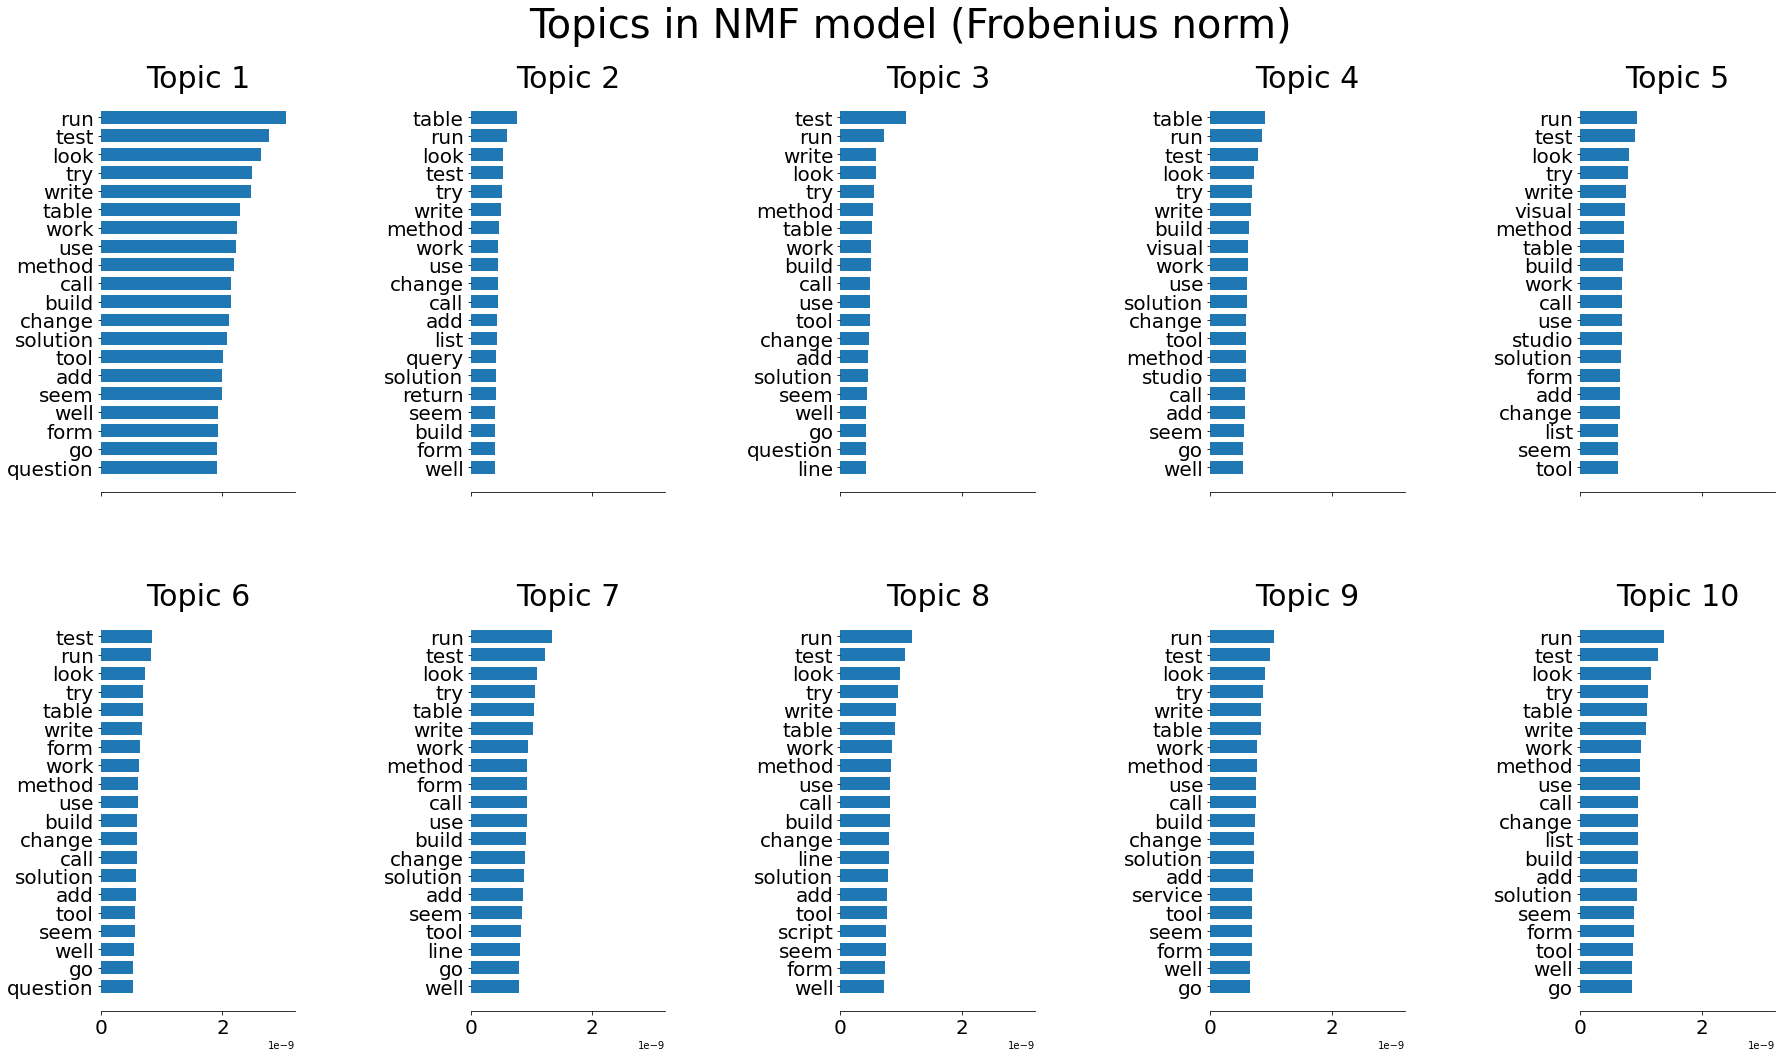

In [19]:
# Fit the NMF model with Frobenius norm :
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time.time()
nmf = NMF(n_components=n_components, 
          init='nndsvda', #random_state=1,
          alpha_W=0.1, alpha_H="same", l1_ratio=0) ## pas de pénalisation L1 sinon 0 partout
nmf = nmf.fit(tfidf)
print("done in %0.3fs." % (time.time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words( nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)")



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.443s.


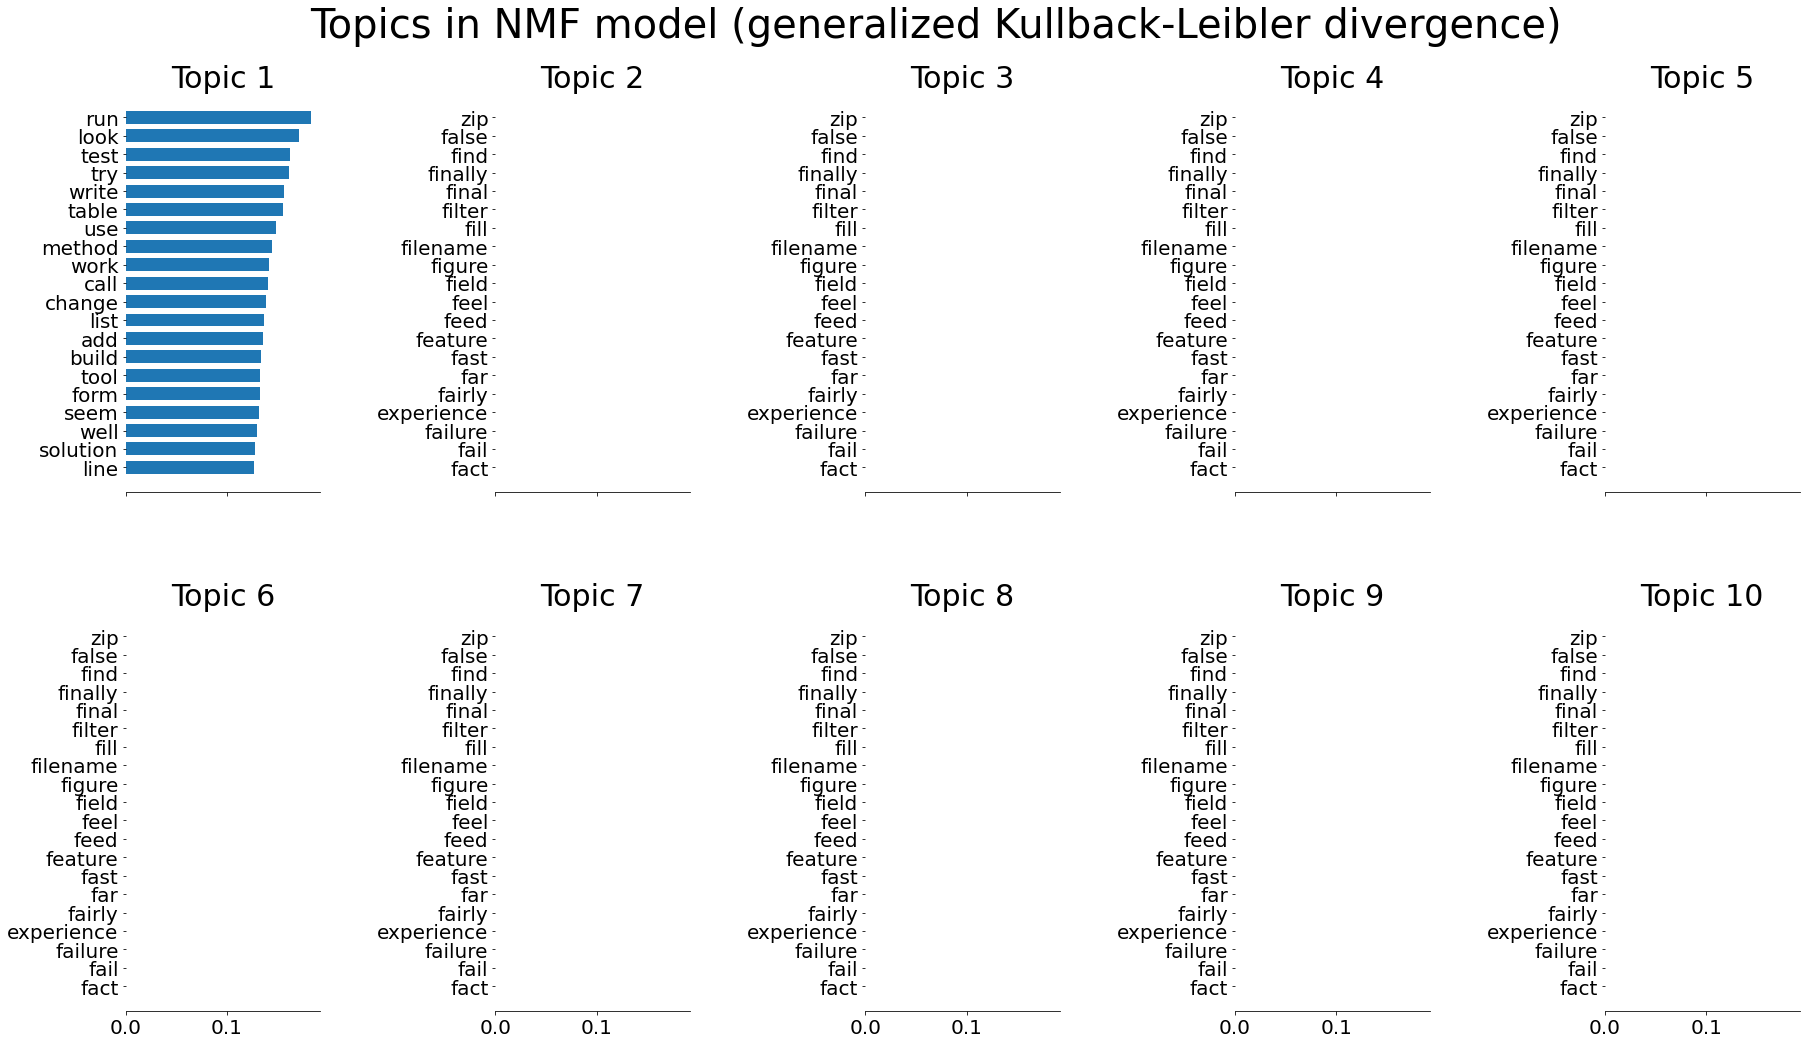

In [23]:
# Fit the NMF model with KL divergence
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time.time()
nmf = NMF(
    n_components=n_components,init = "nndsvda",
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.1, alpha_H="same",
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time.time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 7.648s.


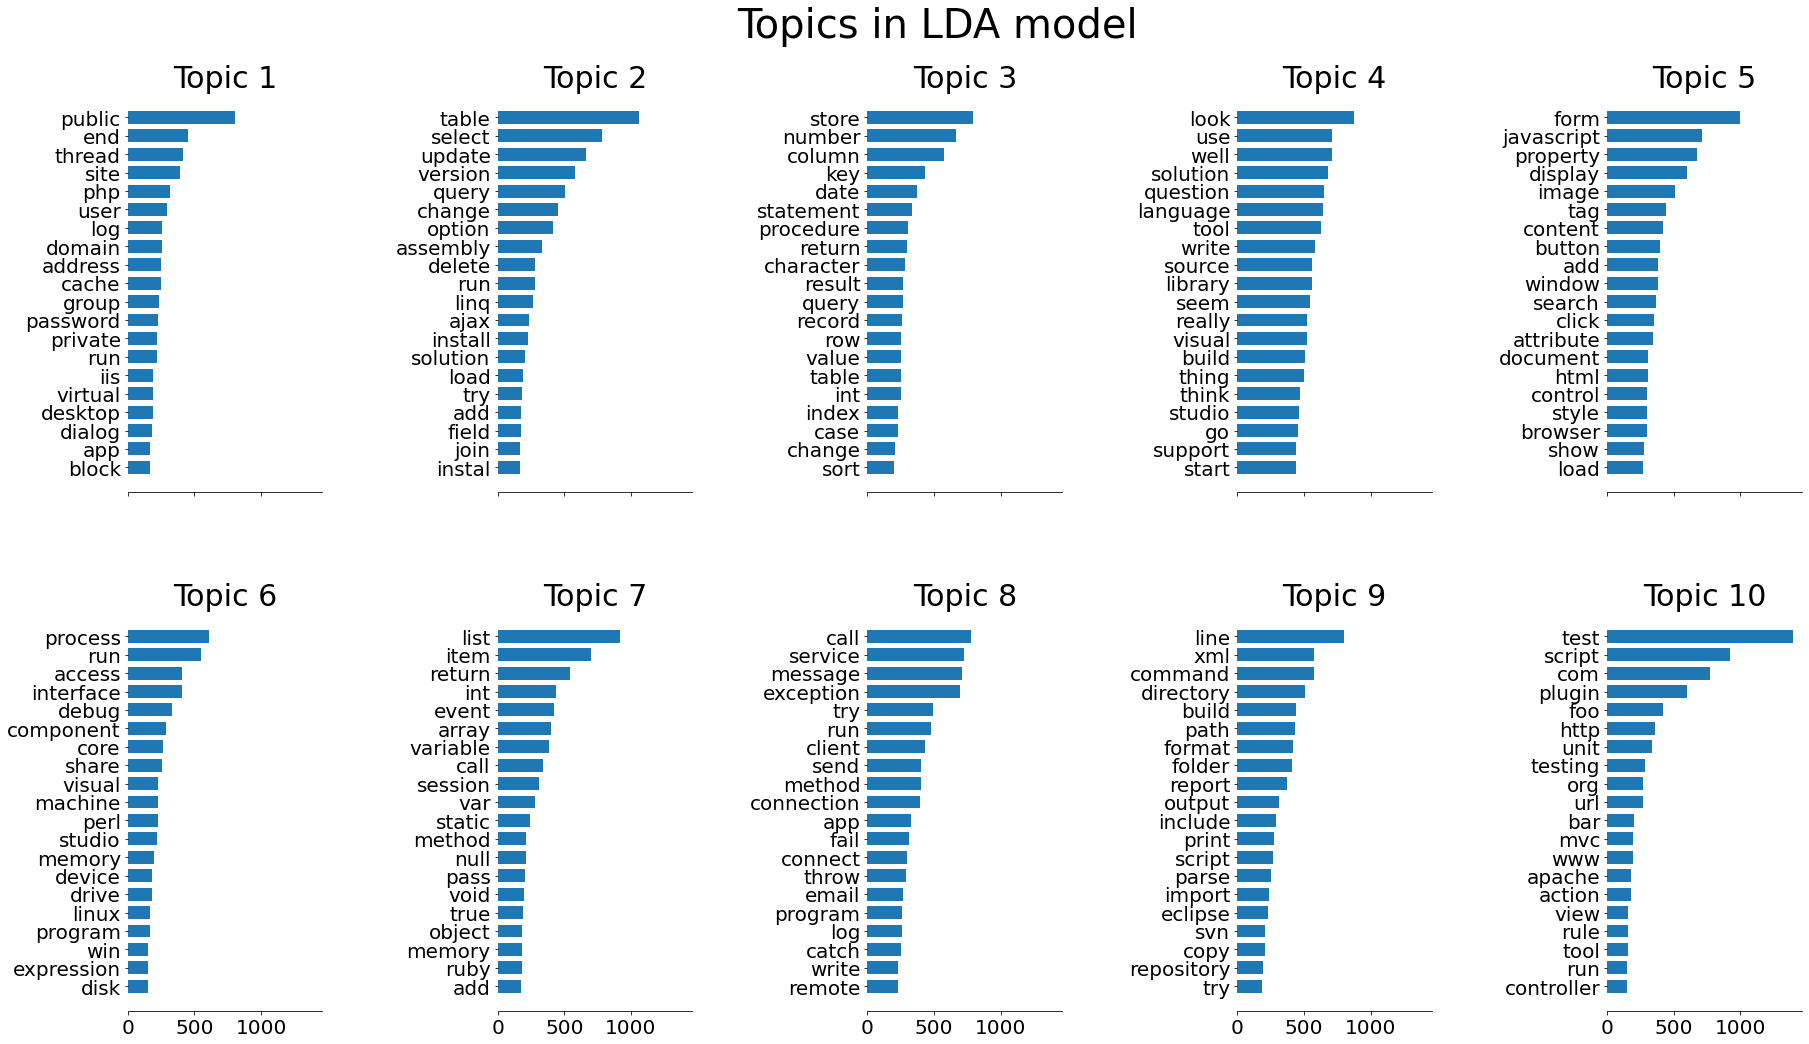

In [21]:
## LDA : 
print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components, 
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time.time()
lda.fit(tf)
print("done in %0.3fs." % (time.time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")


<a id ="section2.3"></a>
[back to menu](#menu)

## 2.C Optimisation des hyper-paramètres du LDA :
Je reviens au LDA, pour laquelle il faut fixer les "bons" choix de paramètres. Une validation croisée s'impose alors. Je construit un pipe python :
* La vectorisation a déjà été faite, je garde toutes les features quitte à ajouter une pénalisation lasso
* La LDA a différents paramètres à fixer : 
    * n_components = Number of topics.
    * max_iter=5 : The maximum number of passes over the training data (aka epochs)
    * learning_decay = 0.7 -> (0.5, 1.0] : It is a parameter that control learning rate in the online learning method.
    * learning_offset=50.0, : A (positive) parameter that downweights early iterations in online learning
* Le score proposé pour la LDA dans sklarn est la log-vraissemblance approchée. Cependant, vu que le lien texte/tag n'est pas encore traité, cela n'aura pas tant de sens de comparer à une sortie. Il sera plus intéressant de regarder la perplexité (aussi donnée dans la LDA de sklearn) Cependant, il y a l'air d'y avoir un [bug dans l'implémentation de la perplexité](https://github.com/scikit-learn/scikit-learn/issues/6777) dans sklearn.

In [24]:
def pseudo_cv_X_sparse(X_,  my_meth, param_grid, my_score, cv = 5):
    ## MAP THE DICT OF LIST INTO LIST OF DICT :
    param_dirg = model_selection.ParameterGrid(param_grid)

    ## INITIALIZATION : 
    res = {} # dict of dict 
    res["params"]=[]
    for kwargs in param_dirg :
        res["params"].append(kwargs)
    dict_score = {}
    dict_time_fit = {}
    dict_time_predict = {}

    k_iter = 1
    n_fold = 0 # just for print purpose 
    ## SET FOLDS :
    kf = model_selection.KFold(n_splits = 5)
    y=None
    CV_split_iterator = kf.split(X_,y) 

    ## LOOP ON FOLDS :
    for CV_train_range_index, CV_test_range_index in CV_split_iterator : 
        n_fold += 1 
        print("Fold "+str(n_fold))
        ## extract train
        train_index = X_.index[CV_train_range_index]
        train = X_.iloc[CV_train_range_index]
        ## extract test : 
        test_index = X_.index[CV_test_range_index]
        test = X_.iloc[CV_test_range_index]
        ## LOOP ON PARAM NAMES (HERE ONLY 1)
        fold_key = "fold"+str(k_iter)
        ## init fold dict
        dict_score[fold_key] = []
        dict_time_fit[fold_key] = []
        dict_time_predict[fold_key] = []
        ## loop on different set of kwargs 
        for kwargs in param_dirg :
            print(kwargs)
            ## SET PARAMS IN METH :
            my_meth.set_params(**kwargs)
            ## PREDICT TEST VALUES : 
            t = time.time()
            my_meth.fit(train)
            W = my_meth.transform(test)
            dict_time_fit[fold_key].append(time.time() - t)
            t = time.time()
            H = my_meth.components_
            X_pred = np.dot(W,H)
            dict_score[fold_key].append(my_score(test, X_pred))
            dict_time_predict[fold_key].append(time.time() - t)     
        k_iter += 1
    ## save in same shape as sklearn GridSearchCV     
    df_time_fit = pd.DataFrame(dict_time_fit)
    df_time_predict = pd.DataFrame(dict_time_predict)
    df_score = pd.DataFrame(dict_score)
    res["mean_fit_time"] = df_time_fit.mean(axis=1).values
    res["std_fit_time"] = df_time_fit.std(axis=1).values
    res["mean_score_time"] = df_time_predict.mean(axis=1).values
    res["std_score_time"] = df_time_predict.std(axis=1).values
    res["mean_test_score"] = df_score.mean(axis=1).values
    res["std_test_score"] = df_score.std(axis=1).values
    return(res)

In [25]:
n_features = 1000
n_components = 10
## for print :
n_top_words = 20

In [26]:
## choose vectorizer : 
countvec = CountVectorizer(max_features=n_features,
                          stop_words='english', strip_accents='unicode',)
X = countvec.fit_transform(pd.Series(corpora))
## get right index and split :
X = pd.DataFrame(X.toarray(), index = corpora.keys())
X_train = X.loc[train_index,:]
X_test = X.loc[test_index,:]

param_grid = {"n_components" : [100,500,1000,2000,5000],
              "max_iter" : [5,10,20],
              "learning_decay" : [0.7,0.8,0.9] ,
              "learning_offset" : [50,100]}

# param_grid = {"n_components" : [100],
#               "max_iter" : [5],
#               "learning_decay" : [0.7] ,
#               "learning_offset" : [50]}

my_score = sklearn.metrics.mean_squared_error
my_meth = LatentDirichletAllocation(n_jobs = 8, verbose = 0)

In [27]:
my_score = sklearn.metrics.mean_squared_error
my_meth = LatentDirichletAllocation(n_jobs = 8, verbose = 0)

res = pseudo_cv_X_sparse(X_train,  my_meth, param_grid, my_score, cv = 3)
res

Fold 1
{'learning_decay': 0.7, 'learning_offset': 50, 'max_iter': 5, 'n_components': 100}
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
Fold 2
{'learning_decay': 0.7, 'learning_offset': 50, 'max_iter': 5, 'n_components': 100}
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
Fold 3
{'learning_decay': 0.7, 'learning_offset': 50, 'max_iter': 5, 'n_components': 100}
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
Fold 4
{'learning_decay': 0.7, 'learning_offset': 50, 'max_iter': 5, 'n_components': 100}
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
Fold 5
{'learning_decay': 0.7, 'learning_offset': 50, 'max_iter': 5, 'n_componen

{'params': [{'learning_decay': 0.7,
   'learning_offset': 50,
   'max_iter': 5,
   'n_components': 100}],
 'mean_fit_time': array([3.9394599]),
 'std_fit_time': array([0.23346074]),
 'mean_score_time': array([0.03707933]),
 'std_score_time': array([0.00885923]),
 'mean_test_score': array([51.47175125]),
 'std_test_score': array([4.42966098])}

In [ ]:
res

In [ ]:
sklearn.metrics.mean_squared_error

In [ ]:
lda.fit(X_train)
X_pred = lda.transform(X_test)

In [ ]:
X_pred = pd.DataFrame(X_pred, index = X_test.index)
X_pred.var()

In [ ]:
X_test